In [1]:
import sys
sys.path.append('..')
import torch
from torchmetrics.classification import BinaryF1Score, F1Score
import wandb
from tqdm import trange
import os
from datetime import datetime
from sklearn import metrics
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import pytorch_lightning as pl
import numpy as np

sys.path.insert(0, '/Users/evanpan/Documents/GitHub/EvansToolBox/Utils')
sys.path.insert(0, '/Users/evanpan/Desktop/openpose/python/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/EvansToolBox/Utils/')
sys.path.insert(0, '/scratch/ondemand27/evanpan/Gaze_project/')

# from training.model import *
from Dataset_Util.dataloader import *

In [2]:
%load_ext autoreload
%autoreload 1

%aimport training.model
%aimport Dataset_Util.dataloader

# Loaded Things

In [3]:
dataset_location = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset"
model_save_location = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models"
config = json.load(open("/scratch/ondemand27/evanpan/Gaze_project/training/baseline_config.json", "r"))

## Load dataset

In [4]:
# do the training test split here:
dataset_metadata = "/scratch/ondemand27/evanpan/data/deep_learning_processed_dataset/video_to_window_metadata.json"
dataset_metadata = json.load(open(dataset_metadata, "r"))
all_videos = list(dataset_metadata.keys())
training_set = []
testing_set = []
# get the name of the videos (this ensures no contamination because the same shot is split)
for i in range(0, len(all_videos)):
    if i / len(all_videos) < 0.9:
        training_set.append(all_videos[i])
    else:
        testing_set.append(all_videos[i])

In [5]:
class SentenceBaseline_Gaze_and_Direction_PredictionModel_no_chimera(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(SentenceBaseline_Gaze_and_Direction_PredictionModel_no_chimera, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)        

        # directional output layers
        self.directional_output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.directional_output_layer_1 = nn.Sequential(self.directional_output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.directional_output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.directional_output_layer_2 = nn.Sequential(self.directional_output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.directional_output_layer_3 = nn.Linear(config["output_layer_2_hidden"], 4)
        self.directional_output_layer_3 = nn.Sequential(self.directional_output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_self[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_self(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        out, hidden_state = self.lstm(x_combined)
        # bn
        x_dir = self.activation(out)
        x_dir = self.directional_output_layer_1(x_dir)
        x_dir = self.directional_output_layer_2(x_dir)
        x_dir = self.directional_output_layer_3(x_dir)
        return x_dir
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

In [6]:
class SentenceBaseline_Gaze_and_Direction_PredictionModel_only_updown_no_chimera(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(SentenceBaseline_Gaze_and_Direction_PredictionModel_only_updown_no_chimera, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)        

        # directional output layers
        self.directional_output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.directional_output_layer_1 = nn.Sequential(self.directional_output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.directional_output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.directional_output_layer_2 = nn.Sequential(self.directional_output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.directional_output_layer_3 = nn.Linear(config["output_layer_2_hidden"], 3)
        self.directional_output_layer_3 = nn.Sequential(self.directional_output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_self[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_self(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        out, hidden_state = self.lstm(x_combined)
        # bn
        x_dir = self.activation(out)
        x_dir = self.directional_output_layer_1(x_dir)
        x_dir = self.directional_output_layer_2(x_dir)
        x_dir = self.directional_output_layer_3(x_dir)
        return x_dir
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

In [7]:
class SentenceBaseline_Gaze_and_Direction_PredictionModel(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(SentenceBaseline_Gaze_and_Direction_PredictionModel, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)        
        # aversion output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], config["output_layer_3_hidden"])
        self.output_layer_3 = nn.Sequential(self.output_layer_3)

        # directional output layers
        self.directional_output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.directional_output_layer_1 = nn.Sequential(self.directional_output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.directional_output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.directional_output_layer_2 = nn.Sequential(self.directional_output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.directional_output_layer_3 = nn.Linear(config["output_layer_2_hidden"], 4)
        self.directional_output_layer_3 = nn.Sequential(self.directional_output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_self[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_self(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        out, hidden_state = self.lstm(x_combined)
        # bn
        # x = self.bn(out.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.activation(out)
        x = self.output_layer_1(x)
        x = self.output_layer_2(x)
        x = self.output_layer_3(x)

        x_dir = self.activation(out)
        x_dir = self.directional_output_layer_1(x_dir)
        x_dir = self.directional_output_layer_2(x_dir)
        x_dir = self.directional_output_layer_3(x_dir)
        return x, x_dir
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

In [8]:
class SentenceBaseline_Gaze_and_Direction_PredictionModel_only_updown(nn.Module):
    def __init__(self, config):
        torch.set_default_tensor_type(torch.DoubleTensor)
        # initialize model
        super(SentenceBaseline_Gaze_and_Direction_PredictionModel_only_updown, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.activation = nn.Sigmoid()
        self.num_layers = config["num_layers"]
        self.config = config
        # the feature of each speaker are encoded with a separate Linear Layer
        self.input_layer_self = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        self.input_layer_other = nn.Linear(int(config["input_dims"]/2 - 6), config["input_layer_out"])
        
        # the Recurrent Layer will take care of the next step
        self.lstm_hidden_dims = config["lstm_output_feature_size"]
        self.num_lstm_layer = config["lstm_layer_num"]
        self.frames_ahead = config["frames_ahead"]
        self.frames_behind = config["frames_behind"]
        self.lstm = nn.LSTM(2 * (config["input_layer_out"] + 6) * (self.frames_ahead + self.frames_behind + 1), 
                            self.lstm_hidden_dims, 
                            self.num_lstm_layer, 
                            batch_first=True)        
        # aversion output layers
        self.output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.output_layer_1 = nn.Sequential(self.output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.output_layer_2 = nn.Sequential(self.output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.output_layer_3 = nn.Linear(config["output_layer_2_hidden"], config["output_layer_3_hidden"])
        self.output_layer_3 = nn.Sequential(self.output_layer_3)

        # directional output layers
        self.directional_output_layer_1 = nn.Linear(self.lstm_hidden_dims, config["output_layer_1_hidden"])
        self.directional_output_layer_1 = nn.Sequential(self.directional_output_layer_1, self.activation, nn.Dropout(self.config["dropout"]))
        self.directional_output_layer_2 = nn.Linear(config["output_layer_1_hidden"], config["output_layer_2_hidden"])
        self.directional_output_layer_2 = nn.Sequential(self.directional_output_layer_2, self.activation, nn.Dropout(self.config["dropout"]))
        self.directional_output_layer_3 = nn.Linear(config["output_layer_2_hidden"], 3)
        self.directional_output_layer_3 = nn.Sequential(self.directional_output_layer_3)

        # audio_filler = torch.tensor([[[-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715]]]).to(self.device)
        # text_filler = torch.ones([1, 1, 772]).to(self.device) * -15
        # text_filler[:, :, -4:] = 0
        # self.filler = torch.concat([audio_filler, text_filler], axis=2)
    def concate_frames(self, input_feature):
        # here I expect the 
        padding_front = torch.zeros([input_feature.shape[0], self.frames_ahead, input_feature.shape[2]]).to(self.device)
        padding_back = torch.zeros([input_feature.shape[0], self.frames_behind, input_feature.shape[2]]).to(self.device)
        padded_input_audio = torch.cat([padding_front, input_feature, padding_back], dim=1)
        window_audio = []
        for i in range(0, input_feature.shape[1]):
            window_count = i + self.frames_ahead
            current_window = padded_input_audio[:, window_count-self.frames_ahead:window_count+self.frames_behind+1]
            s = current_window.shape
            current_window = current_window.view((s[0], s[1] * s[2]))
            current_window = torch.unsqueeze(current_window, 1)
            window_audio.append(current_window)
        rtv = torch.cat(window_audio, dim=1)
        return rtv
    def forward(self, input_feature):
        feature_size = int(input_feature.size()[2] / 2)
        mod_audio_self = input_feature[:, :, :feature_size]
        mod_audio_other = input_feature[:, :, feature_size:]
        
        text_feature_self = mod_audio_self[:, :, :6]
        mod_audio_self = mod_audio_self[:, :, 6:]
        text_feature_other = mod_audio_self[:, :, :6]
        mod_audio_other = mod_audio_other[:, :, 6:]
        x1 = self.activation(self.input_layer_self(mod_audio_self))
        x2 = self.activation(self.input_layer_self(mod_audio_other))
        x1_windowed = self.concate_frames(x1)
        x2_windowed = self.concate_frames(x2)
        x_combined = torch.concat([x1_windowed, text_feature_self, x2_windowed, text_feature_other], axis=2)
        # here I'm assuming that the input_audio is of proper shape
        out, hidden_state = self.lstm(x_combined)
        # bn
        # x = self.bn(out.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.activation(out)
        x = self.output_layer_1(x)
        x = self.output_layer_2(x)
        x = self.output_layer_3(x)

        x_dir = self.activation(out)
        x_dir = self.directional_output_layer_1(x_dir)
        x_dir = self.directional_output_layer_2(x_dir)
        x_dir = self.directional_output_layer_3(x_dir)
        return x, x_dir
    def load_weights(self, pretrained_dict):
    #   not_copy = set(['fc.weight', 'fc.bias'])
        model_dict = self.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_dict.items()}
        model_dict.update(pretrained_dict)
        self.load_state_dict(model_dict)

# Training for sentence + word + audio. but also uses velocity as a loss function, also predict gaze Direction

In [9]:
def train_model_with_for_direction_no_chimera(model, config, train_data, valid_data, wandb, model_name, start = 1):
    optimiser = torch.optim.Adam(model.parameters(), lr=config["learning_rate"])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train() 
    loss_fn2 = nn.CrossEntropyLoss()
    loss_fn_vel = nn.MSELoss()
    training_loss = []
    valid_loss = []
    training_f1 = []
    valid_f1 = []
    aversion_vs_start = []
    count = 0
    f1_score_direction = F1Score(task="multiclass", num_classes=4, average="weighted").to(device)
    for epoch in range(start, config['epochs'] + 1):
        total_train_loss = 0
        total_valid_loss = 0
        total_direct_gaze_predicted = 0
        # total_train_f1 = 0
        # total_valid_f1 = 0
        total_train_direction_f1 = 0
        total_valid_direction_f1 = 0
        train_batch_counter = 0
        valid_batch_counter = 0
        total_prediction_counter = 0
        prediction_mean = 0
        prediction_std = 0
        model.zero_grad()
        for _, (X, [Y, Y_dir]) in enumerate(train_data):
            train_batch_counter += 1
            X, Y, Y_dir= X.to(device), Y.to(device), Y_dir.to(device)   
            optimiser.zero_grad()
            if "Transformer" in config["model_type"]:
                all_zero = torch.zeros(Y.shape).to(device)
                dire_pred = model(X, all_zero)
            else:
                dire_pred = model(X)
            # loss for the directional classification
            loss = loss_fn2(dire_pred.transpose(2, 1), torch.argmax(Y_dir, axis=2).long())
            # get the softmax
            loss.backward()
            optimiser.step()
            total_train_loss += loss.item()
            # binary_pred = torch.round(pred)
            max_dire_pred = torch.argmax(dire_pred, dim=2, keepdim=True)
            max_dire_pred = torch.zeros_like(dire_pred).scatter_(2, max_dire_pred, 1)
            dire_pred = torch.argmax(dire_pred, axis=2, keepdim=True)
            # f1_train = f1_score(binary_pred, torch.unsqueeze(Y, axis=2)).item()
            f1_dire_train = f1_score_direction(dire_pred, torch.argmax(Y_dir, axis=2, keepdim=True)).item()

            # prediction_mean = torch.mean(binary_pred.float()).item()
            # prediction_std = torch.std(binary_pred.float()).item()            
            total_direct_gaze_predicted += torch.sum(max_dire_pred[:, :, 0]).item()
            total_prediction_counter += float(dire_pred.size()[0] * dire_pred.size()[1] )
            # total_train_f1 += f1_train
            total_train_direction_f1 += f1_dire_train
            del X, Y, Y_dir, dire_pred
            torch.cuda.empty_cache()

        # total_train_f1 /= train_batch_counter
        total_train_direction_f1 /= train_batch_counter
        total_train_loss /= len(train_data)
        total_direct_gaze_predicted /= total_prediction_counter
        
        for _, (X, [Y, Y_dir]) in enumerate(valid_data):
            with torch.no_grad():
                valid_batch_counter += 1
                X, Y, Y_dir= X.to(device), Y.to(device), Y_dir.to(device)   
                if "Transformer" in config["model_type"]:
                    all_zero = torch.zeros(Y.shape).to(device)
                    dire_pred = model(X, all_zero)
                else:
                    dire_pred = model(X)
                loss = loss_fn2(dire_pred.transpose(2, 1), torch.argmax(Y_dir, axis=2).long())
                total_valid_loss += loss.item()

                # binary_pred = torch.round(pred)
                dire_pred = torch.argmax(dire_pred, axis=2, keepdim=True)
                f1_dire_valid = f1_score_direction(dire_pred, torch.argmax(Y_dir, axis=2, keepdim=True)).item()

                total_valid_direction_f1 += f1_dire_valid
                del X, Y, Y_dir
                torch.cuda.empty_cache()
        total_valid_direction_f1 /= valid_batch_counter
        total_valid_loss /= len(valid_data)

        if config['wandb']:
            wandb.log({'training loss': total_train_loss,
                        'validation_loss': total_valid_loss,
                        'training_f1_direction': total_train_direction_f1,
                        'validation_f1_direction': total_valid_direction_f1,
                        "percentage_predicted_aversion": total_direct_gaze_predicted})
        training_loss.append(total_train_loss)
        valid_loss.append(total_valid_loss)
        training_f1.append(total_train_direction_f1)
        valid_f1.append(total_valid_direction_f1)
        aversion_vs_start.append(total_direct_gaze_predicted)
        if total_valid_direction_f1 == max(valid_f1):
            try:
                os.mkdir(os.path.join(*[model_save_location, model_name]))
            except:
                pass
            config_save_path = os.path.join(*[model_save_location, model_name, "config.json"])
            json.dump(config, open(config_save_path, "w"))
            file_name = f'time={datetime.now()}_epoch={epoch}.pt'
            save_path = os.path.join(*[model_save_location, model_name, file_name])
            torch.save(model.state_dict(), save_path)
        if config['early_stopping']>0:
            if epoch > 1:
                if total_valid_direction_f1 <= np.mean(valid_f1[epoch - 7:epoch - 2]):
                    count += 1
                else:
                    count = 0
            if count >= config['early_stopping']:
                print('\n\nStopping early due to decrease in performance on validation set\n\n')
                break 
        if count == 0:
            print("Epoch {}, percentage of direct gaze: {}\ntraining L: {}\nvalidation L:{}".format(epoch, total_direct_gaze_predicted, total_train_direction_f1, total_valid_direction_f1))
        else:
            print("Epoch {}, percentage of direct gaze: {}\ntraining L: {}\nvalidation L:{}, model have not improved for {} iterations".format(epoch, total_direct_gaze_predicted, total_train_direction_f1, total_valid_direction_f1, count))
    if config['wandb']:
        save_path = os.path.join(*[model_save_location, model_name, file_name])
        wandb.save(save_path)

In [59]:
torch.manual_seed(0)
run_obj = None
config = json.load(open("/scratch/ondemand27/evanpan/Gaze_project/training/sentence_config2.json", "r"))
# run_obj = wandb.init(project="gaze_prediction", config=config, settings=wandb.Settings(start_method="fork"))
config["wandb"] = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# obtain the dataset
torch.set_default_tensor_type(torch.DoubleTensor)
training_dataset = Aversion_and_Directions_SelfTap111(dataset_location, training_set[:10], sentence_and_word_timing=True, velocity_label=False, simple_dir=True)
validation_dataset = Aversion_and_Directions_SelfTap111(dataset_location, testing_set[:2], sentence_and_word_timing=True, velocity_label=False, simple_dir=True)
train_dataloader = torch.utils.data.DataLoader(training_dataset, config['batch_size'], True)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset, config['batch_size'], True)
model = SentenceBaseline_Gaze_and_Direction_PredictionModel_only_updown_no_chimera(config)
model.to(device)
# training_dataset[0]
train_model_with_for_direction_no_chimera(model, config, train_dataloader, valid_dataloader, run_obj, "aversion_and_direction_no_chimera_only_updown")
# run_obj.finish()

Epoch 1, percentage of direct gaze: 0.0023206106870229007
training L: 0.1277031219019863
validation L:0.0900270901783316
Epoch 2, percentage of direct gaze: 0.016763358778625954
training L: 0.14371141250113667
validation L:0.16054867576668225
Epoch 3, percentage of direct gaze: 0.07621374045801527
training L: 0.20060795270226067
validation L:0.3062044700556896
Epoch 4, percentage of direct gaze: 0.24079389312977098
training L: 0.31856820400053965
validation L:0.45193750730523047
Epoch 5, percentage of direct gaze: 0.49987786259541983
training L: 0.4210935976498142
validation L:0.5494158574516398
Epoch 6, percentage of direct gaze: 0.7435419847328244
training L: 0.4672748625790007
validation L:0.5821730749944725
Epoch 7, percentage of direct gaze: 0.8909007633587787
training L: 0.47106488397771895
validation L:0.5876710119198193
Epoch 8, percentage of direct gaze: 0.9625954198473282
training L: 0.4592527232529981
validation L:0.5878685287914935
Epoch 9, percentage of direct gaze: 0.9874

TypeError: expected str, bytes or os.PathLike object, not BufferedReader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/aversion_and_direction_larg_batch_no_velocity/config.json", "r"))
model = SentenceBaseline_Gaze_and_Direction_PredictionModel_larger(config)
config["load_model"] = True
if config["wandb"]:
    wandb.login()
    if config["load_model"]:
        run_obj = wandb.init(project="gaze_prediction", config=config, save_code=True,
            resume='allow', id='4b14oz14')
        # checkpoint_name = "gaze_prediction_team/gaze_prediction/8w9fyxan"
        checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/aversion_and_direction_larg_batch_no_velocity/time=2023-04-18 01:53:24.520092_epoch=986.pt"
        wandb.restore(checkpoint_path)
        pretrained_dict = torch.load(checkpoint_path, map_location=device)
        model.load_weights(pretrained_dict)
        model.to(device)
    else:
        run_obj = wandb.init(project="gaze_prediction", config=config, settings=wandb.Settings(start_method="fork"))
else:
    run_obj = None

training_dataset = Aversion_and_Directions_SelfTap111(dataset_location, training_set, sentence_and_word_timing=True, velocity_label=False)
validation_dataset = Aversion_and_Directions_SelfTap111(dataset_location, testing_set, sentence_and_word_timing=True, velocity_label=False)
train_dataloader = torch.utils.data.DataLoader(training_dataset, config['batch_size'], True)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset, config['batch_size'], True)

train_model_with_for_direction(model, config, train_dataloader, valid_dataloader, run_obj, "aversion_and_direction_no_chimera", 0)
run_obj.finish()


KeyboardInterrupt: 

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/aversion_and_direction_larg_batch/config.json", "r"))
model = SentenceBaseline_Gaze_and_Direction_PredictionModel(config)
checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/aversion_and_direction_larg_batch/time=2023-04-18 12:55:52.573531_epoch=2169.pt"
pretrained_dict = torch.load(checkpoint_path, map_location=device)
model.load_weights(pretrained_dict)
model.to(device)

training_dataset = Aversion_and_Directions_SelfTap111(dataset_location, training_set, sentence_and_word_timing=True, velocity_label=False)
validation_dataset = Aversion_and_Directions_SelfTap111(dataset_location, testing_set, sentence_and_word_timing=True, velocity_label=False)
train_dataloader = torch.utils.data.DataLoader(training_dataset, config['batch_size'], True)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset, config['batch_size'], True)
preds = []
targets = []
for _, (X, [Y, Y_dir]) in enumerate(train_dataloader):
    with torch.no_grad():
        X, Y, Y_dir= X.to(device), Y.to(device), Y_dir.to(device)   
        if "Transformer" in config["model_type"]:
            all_zero = torch.zeros(Y.shape).to(device)
            pred, dire_pred = model(X, all_zero)
        else:
            pred, dire_pred = model(X)
            
        max_dire_pred = torch.flatten(torch.argmax(dire_pred, dim=2)).data.cpu().numpy()
        max_dire_target = torch.flatten(torch.argmax(Y_dir, dim=2)).data.cpu().numpy()
        preds.extend(max_dire_pred)
        targets.extend(max_dire_target)

    # dire_pred = torch.softmax(dire_pred[:, :, :], dim=2)
    # dire_pred = dire_pred.cpu().detach().numpy()
    # plt.plot(dire_pred[5])

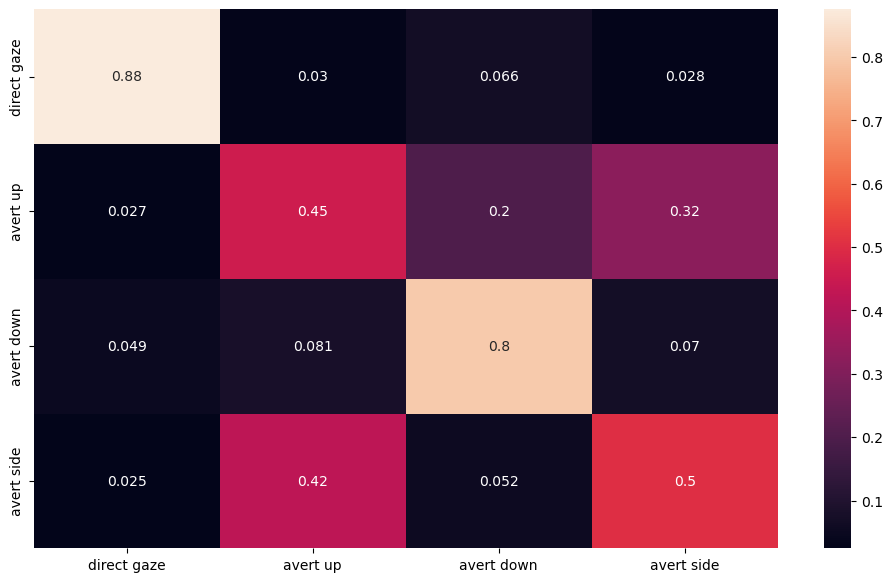

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
classes = ("direct gaze", "avert up", "avert down", "avert side")

# Build confusion matrix
cf_matrix = confusion_matrix(preds, targets)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = json.load(open("/scratch/ondemand27/evanpan/data/Gaze_aversion_models/aversion_and_direction_larg_batch_simple_dir/config.json", "r"))
model = SentenceBaseline_Gaze_and_Direction_PredictionModel_only_updown(config)
checkpoint_path = "/scratch/ondemand27/evanpan/data/Gaze_aversion_models/aversion_and_direction_larg_batch_simple_dir/time=2023-04-19 16:19:06.919275_epoch=1088.pt"
pretrained_dict = torch.load(checkpoint_path, map_location=device)
model.load_weights(pretrained_dict)
model.to(device)

training_dataset = Aversion_and_Directions_SelfTap111(dataset_location, training_set, sentence_and_word_timing=True, velocity_label=False, simple_dir=True)
validation_dataset = Aversion_and_Directions_SelfTap111(dataset_location, testing_set, sentence_and_word_timing=True, velocity_label=False, simple_dir=True)
train_dataloader = torch.utils.data.DataLoader(training_dataset, config['batch_size'], True)
valid_dataloader = torch.utils.data.DataLoader(validation_dataset, config['batch_size'], True)
preds = []
targets = []
for _, (X, [Y, Y_dir]) in enumerate(valid_dataloader):
    with torch.no_grad():
        X, Y, Y_dir= X.to(device), Y.to(device), Y_dir.to(device)   
        if "Transformer" in config["model_type"]:
            all_zero = torch.zeros(Y.shape).to(device)
            pred, dire_pred = model(X, all_zero)
        else:
            pred, dire_pred = model(X)
            
        max_dire_pred = torch.flatten(torch.argmax(dire_pred, dim=2)).data.cpu().numpy()
        max_dire_target = torch.flatten(torch.argmax(Y_dir, dim=2)).data.cpu().numpy()
        preds.extend(max_dire_pred)
        targets.extend(max_dire_target)

    # dire_pred = torch.softmax(dire_pred[:, :, :], dim=2)
    # dire_pred = dire_pred.cpu().detach().numpy()
    # plt.plot(dire_pred[5])

In [ ]:
plt.plot(dire_pred[0])

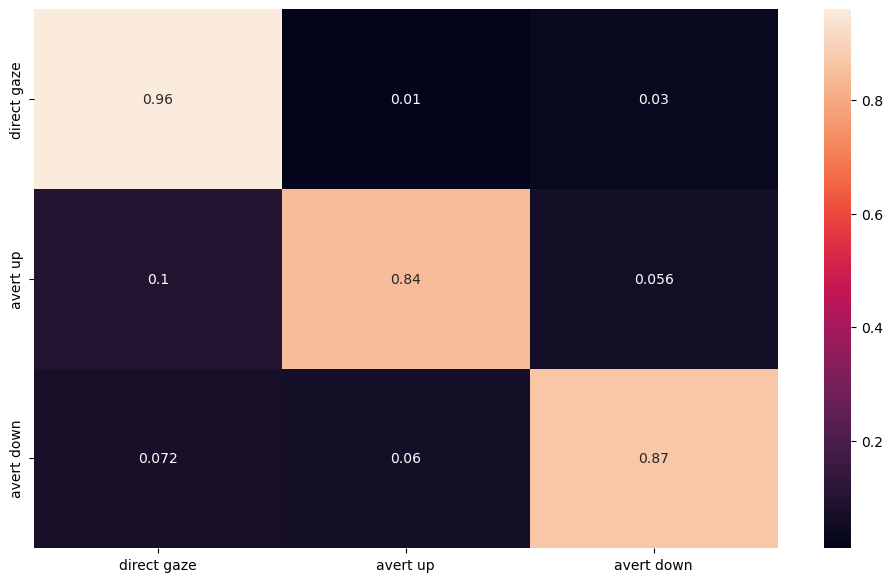

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
classes = ("direct gaze", "avert up", "avert down")

# Build confusion matrix
cf_matrix = confusion_matrix(preds, targets)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.show()